<a href="https://colab.research.google.com/github/mariajosemv/Predicciones-con-Redes-Neuronales/blob/main/clasificacion/dise%C3%B1o_y_evaluacion_del_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#División datos de entrenamiento y datos de prueba



Con el dataset ya consolidado procedemos a seleccionar las muestras de entrenamiento, validación y prueba

In [1]:
from google.colab import drive
#drive.mount('/content/drive/My Drive/Colab Notebooks')
drive.mount('/content/drive')

%cd '/content/drive/My Drive/Colab Notebooks/Platzi/curso-redes-neuronales/github/clasificacion'
%ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Platzi/curso-redes-neuronales/github/clasificacion
datasets/  diseño_y_evaluacion_del_modelo.ipynb  ingenieria_de_datos.ipynb


In [2]:
# importar librerias necesarias
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

In [3]:
variables_consolidadas = pd.read_parquet('./datasets/variables_consolidadas.parquet')
variables_consolidadas.shape

(2197291, 178)

In [ ]:
objetivo = variables_consolidadas['outcome']
variables_consolidadas.drop('outcome', axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

#Entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.2,random_state=2020)
#Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.1, random_state=2020)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (1582048, 177)
Shape of x_test: (439459, 177)
Shape of x_val: (175784, 177)
Shape of y_train: (1582048,)
Shape of y_test: (439459,)
Shape of y_val: (175784,)


# Arquitectura Propuesta



Una vez consolidado los sets de información de entrenamiento, validacion y pruebas ya podemos iniciar a modelar nuestra red neuronal con las siguientes consideraciones:

- Debido a que el problema consiste en un clasificador binario la función de perdidas más recomendada es `binary_crossentropy`.

- De manera similar una función de activación que se adecua al tipo de problema es la `sigmoid`.

- La metrica para evaluación sera la precisión `accuracy`

- Debido a la gran cantidad de información el entrenamiento tomara más tiempo, en este escenario se implementaran arquitecturas más pequeñas con pocas epocas de entrenamiento y se escalará el modelo a medida los resultados del accuracy mejoren.

- El número de neuronas por capas se escogió nuevamente siguiendo [la regla empírica](https://www.notion.so/mariajosemv/Redes-neuronales-en-Keras-y-ScikitLearn-b8fcf479b0464021bb85d1b2a8863404#bb16b90c6737471db4ff4451244bf4c5). 

## Red neuronal de una capa oculta

In [ ]:
#Red neuronal pequeña
model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid")) 
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               45568     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 111,617
Trainable params: 111,617
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=64)

Epoch 1/3
24720/24720 [==============================] - 79s 3ms/step - loss: 302.4033 - accuracy: 0.6713 - val_loss: 0.4606 - val_accuracy: 0.7945
Epoch 2/3
24720/24720 [==============================] - 78s 3ms/step - loss: 0.6086 - accuracy: 0.6910 - val_loss: 0.5546 - val_accuracy: 0.7479
Epoch 3/3
24720/24720 [==============================] - 77s 3ms/step - loss: 0.6816 - accuracy: 0.5695 - val_loss: 0.6888 - val_accuracy: 0.5584


👉 Los accuracy no han cambiado mucho, por lo que la red no está aprendiendo.

👉 Un accuracy de 50% es equivalente a clasificar al azar.

Se aumentará la cantidad de capas ocultas para añadir funciones no lineales que permitan hacer una mejor clasificación y obtener un mejor accuracy. 

## Red neuronal de 2 capas ocultas

In [ ]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=64)

Epoch 1/3
24720/24720 [==============================] - 196s 8ms/step - loss: 66.5312 - accuracy: 0.5540 - val_loss: 0.6866 - val_accuracy: 0.5573
Epoch 2/3
24720/24720 [==============================] - 194s 8ms/step - loss: 1.1129 - accuracy: 0.5561 - val_loss: 0.6866 - val_accuracy: 0.5573
Epoch 3/3
24720/24720 [==============================] - 192s 8ms/step - loss: 0.7010 - accuracy: 0.5561 - val_loss: 0.6866 - val_accuracy: 0.5573


A pesar de haber escalado el tamaño de la red los resultados siguen siendo decepcionantes. En este caso el mejor paso a seguir es **volver a validar los datos disponibles**. En este punto existen dos opciones a explorar: 
* Estandarizar las variables numericas disponibles.
* Volver a realizar el One Hot Encoding.

## Estandarización

Consiste en asegurar que los datos sean coherentes entre sí; es decir, que cada tipo de datos tenga el mismo contenido y formato. Los valores estandarizados son útiles para el entrenamiento de datos que no presentan las mismas escalas, o que miden diferentes variables. [🔗](https://www.notion.so/mariajosemv/Fundamentos-de-estad-stica-y-an-lisis-de-datos-con-Python-593076c39bcb400a84e636ec9be289b8#3266210128774ac0966c377dac8f3417)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train) # solo con x_train porque y_train ya esta estandarizada (outcome)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)


print(x_train.shape)
print(y_train.shape)

(1582048, 177)
(1582048,)


In [ ]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=3, batch_size=64)

Epoch 1/3
24720/24720 [==============================] - 191s 8ms/step - loss: 0.1981 - accuracy: 0.9124 - val_loss: 0.1435 - val_accuracy: 0.9404
Epoch 2/3
24720/24720 [==============================] - 194s 8ms/step - loss: 0.1196 - accuracy: 0.9512 - val_loss: 0.1088 - val_accuracy: 0.9571
Epoch 3/3
24720/24720 [==============================] - 195s 8ms/step - loss: 0.0930 - accuracy: 0.9633 - val_loss: 0.0957 - val_accuracy: 0.9630


Con sólo la estandarización de la información el desempeño del modelo ha mejorado drasticamente logrando una precision del 96%! Podriamos seguir evaluanto redes más grandes, pero es un valor aceptable para nosotros por el momento. 

El desempeño con el set de prueba sigue siendo bueno por lo cual ya podemos emplear la arquitectura definida y realizar un entrenamiento con un mayor número de epocas.

In [ ]:
model = Sequential()
model.add(Dense(512,input_dim = x_train_scaled.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(x_train_scaled,y_train, validation_data = (x_val_scaled,y_val),epochs=12, batch_size=64)

Epoch 1/12
24720/24720 [==============================] - 194s 8ms/step - loss: 0.1969 - accuracy: 0.9131 - val_loss: 0.1399 - val_accuracy: 0.9419
Epoch 2/12
24720/24720 [==============================] - 189s 8ms/step - loss: 0.1175 - accuracy: 0.9527 - val_loss: 0.1058 - val_accuracy: 0.9583
Epoch 3/12
24720/24720 [==============================] - 189s 8ms/step - loss: 0.0911 - accuracy: 0.9641 - val_loss: 0.0928 - val_accuracy: 0.9638
Epoch 4/12
24720/24720 [==============================] - 193s 8ms/step - loss: 0.0769 - accuracy: 0.9700 - val_loss: 0.0810 - val_accuracy: 0.9699
Epoch 5/12
24720/24720 [==============================] - 192s 8ms/step - loss: 0.0675 - accuracy: 0.9739 - val_loss: 0.0778 - val_accuracy: 0.9715
Epoch 6/12
24720/24720 [==============================] - 188s 8ms/step - loss: 0.0607 - accuracy: 0.9766 - val_loss: 0.0720 - val_accuracy: 0.9745
Epoch 7/12
24720/24720 [==============================] - 189s 8ms/step - loss: 0.0563 - accuracy: 0.9784 - val_

El siguiente paso es probar este mismo modelo con información que la red nunca haya visto (set de prueba)

In [ ]:
result = model.evaluate(x_test_scaled,y_test)
for i in range(len(model.metrics_names)):
 print("Metric ",model.metrics_names[i],":",
str(round(result[i],2)))

13734/13734 [==============================] - 27s 2ms/step - loss: 0.0640 - accuracy: 0.9796
Metric  loss : 0.06
Metric  accuracy : 0.98


# Evaluación del modelo

La red ha logrado mejorar un poco su desempeño con más epocas de entrenamiento. Finalmente vamos a evaluar gráficamente el desempeño de la función de pérdidas y la presición a traves de cada época de entrenamiento con el fin de validar algun posible sobre-entrenamiento (*overfitting*).

P.D.: Una indicación de que existe *overfitting* es cuando a medida de que se va aumentando la complejidad de la red neuronal, la función de coste del set de entrenamiento se ajusta muchísimo a la función de coste del set de prueba, y luego estas dos funciones comienzan a diverger [🔗](https://www.notion.so/mariajosemv/Redes-neuronales-en-Keras-y-ScikitLearn-b8fcf479b0464021bb85d1b2a8863404#8c1bc491b78b49b99643b321ff29334d).



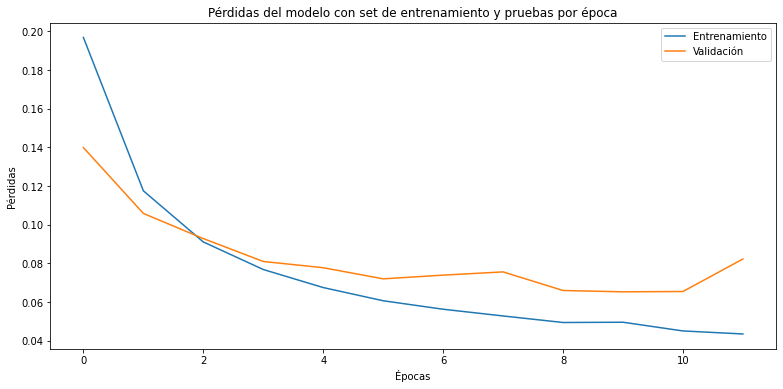

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Pérdidas')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

Se puede apreciar que la función de pérdida disiminuye a medida que aumenta el número de Épocas tanto con la información de entrenamiento como con la de validación. Entre estas dos líneas no se tiene una separación importante que indique la presencia de sobre ajuste por lo que se puede afirmar que el desempeño del modelo es satisfactorio. 

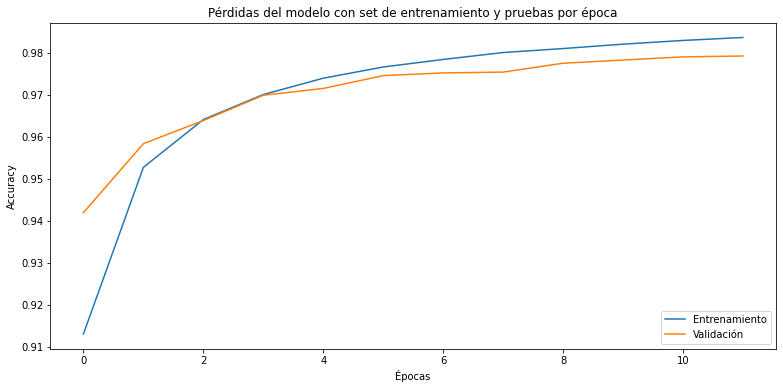

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.show()

De igual manera, los resultados del accuracy tienen valores similares en el set de entrenamiento y validación, y sus gráficas no presentan inidicios de overfitting. En ambos casos, se muestra que el modelo tiene mayor accuracy cuando se soprepasan las 10 épocas de entrenamiento. 